In [1]:
import pandas as pd 
import numpy as np
import math
from utlis import *


tmp = pd.read_csv('Weed_Resistance_Data.csv', sep = ',', header=None)
params_in = list(tmp[:21][0])


params_in = np.array(params_in)

In [2]:
General_TillingFrequency = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
Herbicide_data = np.loadtxt('Corteva/BMP_Matlab_Code/Herbicide_Data.txt')

In [3]:
from utlis import PrepareParams
import numpy as np 

a = 1
Params = PrepareParams()

nYears = int(Params.General.nYears)
nCohorts = int(Params.General.nCohorts)

# nYears = 25
# nCohorts = 2
print("starting year and cohort are: ", nYears, " & ", nCohorts)

H1_eff = [.55,.1,.01]
H2_eff = [0,0,0]
H3_eff = [0,0,0]
H4_eff = [0,0,0]

strategies = []

for i in range(100):
    Population.seedBank = np.zeros((nYears,nGeno,nCohorts))
    # %Lower seed bank density
    Population.lowerBank = np.zeros((nYears,nGeno))
    # %immigrant seed
    Population.immSeed = np.zeros((nYears,nGeno,nCohorts))
    # %emigrant seed
    Population.emSeed = np.zeros((nYears,nGeno,nCohorts))
    # %germination storage
    Population.germination = np.zeros((nYears,nGeno,nCohorts))
    # %ungerminated storage
    Population.ungerminated = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide1 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide2 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide3 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide4 = np.zeros((nYears,nGeno,nCohorts))
    Population.seedProd = np.zeros((nYears,nGeno,nCohorts))
    Population.mature = np.zeros((nYears,nGeno,nCohorts))
    Population.hand = np.zeros((nYears,nGeno,nCohorts))
    Population.immPol = np.zeros((nYears,nGeno,nCohorts))
    Population.emPol = np.zeros((nYears,nGeno,nCohorts))
    Population.newSeed = np.zeros((nYears,nGeno,nCohorts))
    Population.mutated = np.zeros((nYears,nGeno,nCohorts))
    Population.predation = np.zeros((nYears,nGeno,nCohorts))
    Population.winter = np.zeros((nYears,nGeno))
    Population.Res = np.zeros((1, 3))
    Population.seedBank[0,:,0] = Params.General.UpperSeedBank
    Population.lowerBank[0,:] = Params.General.LowerSeedBank

    for y in range(nYears):
        tempSeedBank = np.zeros(81)
        Population.seedBank[y,:,0],Population.lowerBank[y,:] = deepTill(Population.seedBank[y,:,0],
                                                                    Population.lowerBank[y,:],
                                                                    Params.General.TillingFreq,y)

        for c in range(nCohorts):
            # print(" y : ", y, " c", c)
            
            ImmSeed = seedImmigration(nGeno)
            seedBank = Population.seedBank[y,:,c]+ ImmSeed
            seedBank = extinction(seedBank,fieldSize)
            fGerm = Params.Germination.survivalFraction[y,c]
            germination = survival(seedBank,fGerm)
            ungerminated = seedBank - germination
            germination = extinction(germination,fieldSize)
            fCult = Params.Cultivation.survivalFraction[y,c]
            cult = survival(germination,fCult)
            cult = extinction(cult,fieldSize)

            # fSS = 1 - Params.Herbicide1.efficacy_SS[0,0]
            # fRS = 1 - Params.Herbicide1.efficacy_RS[0,0]
            # fRR = 1 - Params.Herbicide1.efficacy_RR[0,0]

            fSS = 1 - H1_eff[0]
            fRS = 1 - H1_eff[1]
            fRR = 1 - H1_eff[2]

            targetLocus = Params.Herbicide1.targetLocus

            herbicide1_ = selectiveSurvival(cult,[fSS,fRS,fRR],targetLocus,Params.key)

            herbicide1 = extinction(herbicide1_,fieldSize)

            # fSS = 1 - Params.Herbicide2.efficacy_SS[y,c]
            # fRS = 1 - Params.Herbicide2.efficacy_RS[y,c]
            # fRR = 1 - Params.Herbicide2.efficacy_RR[y,c]

            fSS = 1 - H2_eff[0]
            fRS = 1 - H2_eff[1]
            fRR = 1 - H2_eff[2]

            targetLocus = Params.Herbicide2.targetLocus

            herbicide2 = selectiveSurvival(herbicide1,[fSS,fRS,fRR],targetLocus,Params.key)
                    
            herbicide2 = extinction(herbicide2,fieldSize)

            fSS = 1 - H3_eff[0]
            fRS = 1 - H3_eff[1]
            fRR = 1 - H3_eff[2]

            targetLocus = Params.Herbicide3.targetLocus

            herbicide3 = selectiveSurvival(herbicide2,[fSS,fRS,fRR],targetLocus,Params.key)
            herbicide3 = extinction(herbicide3,fieldSize)

            fSS = 1 - H4_eff[0]
            fRS = 1 - H4_eff[1]
            fRR = 1 - H4_eff[2]

            targetLocus = Params.Herbicide4.targetLocus

            herbicide4 = selectiveSurvival(herbicide3,[fSS,fRS,fRR],targetLocus,Params.key)
            herbicide4 = extinction(herbicide4,fieldSize)

            A = Params.Mature.maxplants[y,c]
            B = Params.Mature.cropParam[y,c]
            C = Params.Mature.weedCompetition[y,c]

            mature = competition(herbicide4,A,B,C)
            mature = extinction(mature,fieldSize)
            fHand = Params.Hand.survivalFraction[y,c]

            hand = survival(mature,fHand)
            hand = extinction(hand,fieldSize)
            
            A = Params.SeedProd.maxyield[y,c]
            B = Params.SeedProd.cropParam[y,c]
            C = Params.SeedProd.weedCompetition[y,c]

            sum_hand = float(np.sum(hand))
            seedYield = competition(sum_hand,A,B,C)
            
            newFrac = mating(hand,Params.General.selfingCoeff, Params.key)
            seedProd= newFrac*seedYield*Params.General.femaleFrac
            seedProd = extinction(seedProd,fieldSize)

            targetLocus = 1
            muS2R = Params.Mutation.muS2R_locus1[y,c]
            muR2S = Params.Mutation.muR2S_locus1[y,c]
        
            if muS2R==0 and muR2S==0:
                mutated_locus1 = seedProd
            else:
                mutated_locus1 = mutation(seedProd,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus1 = extinction(mutated_locus1,fieldSize)

            targetLocus = 2
            muS2R = Params.Mutation.muS2R_locus2[y,c]
            muR2S = Params.Mutation.muR2S_locus2[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus2 = mutated_locus1
            else:
                mutated_locus2 = mutation(mutated_locus1,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus2 = extinction(mutated_locus2,fieldSize)

            targetLocus = 3
            muS2R = Params.Mutation.muS2R_locus3[y,c]
            muR2S = Params.Mutation.muR2S_locus3[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus3 = mutated_locus2
            else:
                mutated_locus3 = mutation(mutated_locus2,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus3 = extinction(mutated_locus3,fieldSize)

            targetLocus = 4
            muS2R = Params.Mutation.muS2R_locus4[y,c]
            muR2S = Params.Mutation.muR2S_locus4[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus4 = mutated_locus3
            else:
                mutated_locus4 = mutation(mutated_locus3,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus4 = extinction(mutated_locus4,fieldSize)

            fPred = Params.Predation.survivalFraction[y,c]
            predation = survival(mutated_locus4,fPred)
            predation = extinction(predation,fieldSize)


            # print(predation) 
            if Params.General.seedDelay == 0:
                if c < nCohorts-1:
                    Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + predation + ungerminated
                else:
                    tempSeedBank = tempSeedBank + ungerminated + predation
            else:
                tempSeedBank = tempSeedBank + predation
                if c < nCohorts:

                    Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + ungerminated
                else:
                    tempSeedBank = tempSeedBank + ungerminated

            Population.immSeed[y,:,c] = ImmSeed
            Population.ungerminated[y,:,c] = ungerminated
            Population.germination[y,:,c] = germination
            Population.herbicide1[y,:,c] = herbicide1
            Population.herbicide2[y,:,c] = herbicide2
            # Population.herbicide3[y,:,c] = herbicide3
            # Population.herbicide4[y,:,c] = herbicide4
            Population.mature[y,:,c] = mature
            Population.hand[y,:,c] = hand
            Population.seedProd[y,:,c] = seedProd
            Population.predation[y,:,c] = predation
            
        if y != nYears-1:
            fWint_upper = Params.Winter.uppersurvivalFraction[y][c]
            fWint_lower = Params.Winter.lowersurvivalFraction[y][c]

            winter_ = survival(tempSeedBank,fWint_upper)
            winter = extinction(winter_,fieldSize)

            Population.winter[y,:] = winter
            Population.seedBank[y+1,:,0] = Population.seedBank[y+1,:,0] + winter
            Population.lowerBank[y+1,:] = survival(Population.lowerBank[y,:],fWint_lower)
            Population.lowerBank[y+1,:] = extinction(Population.lowerBank[y+1,:],fieldSize)

        else:
            break
        N = nYears*nCohorts

    newPop = np.zeros((N,nGeno))

    k = 0
    for y in range(nYears):
        for c in range(nCohorts):
            newPop[k,:] = Population.seedBank[y,:,c]
            k = k + 1


    Rpop = np.zeros(nYears*nCohorts,)
    for G in range(nGeno):
        for L in range(nLoci):
            if Params.key[L,G] == 2 or Params.key[L,G] == 1:
                Rpop =  Rpop + newPop[:,G]
                break
            
    pltPop = Rpop/np.sum(newPop, axis=1)
    # print(pltPop.shape)

    if sum(pltPop[-5:-1]) > .2:
        strategies.append(pltPop)
        a+=1
        if a % 20 == 0 or i == 999:
            print("total fish caught: ", a)
        




starting year and cohort are:  25  &  1


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


strategies = np.array(strategies)
strategy = np.mean(strategies, axis=0)
strategies = np.array(strategies)
strategy = np.mean(strategies, axis = 0)
dev = np.std(strategies, axis = 0)

result_dict = {}



avg_std = {}
avg_std['average'] = strategy
avg_std['std'] = dev

# molecule = {}

dose = {}

dose['25_55'] = avg_std

# molecule['x713'] = dose





import pickle as pkl
# create a binary pickle file 
# f = open("x713_25_50.pkl","wb")
f = pkl.load( open( "x755_50_81.pkl", "rb" ) )

f['x755'] = dose
## write the python object (dict) to pickle file
pkl.dump( f, open( "x755_25_55.pkl", "wb" ) )

# close file
# f.close()







(-0.1, 1.1)

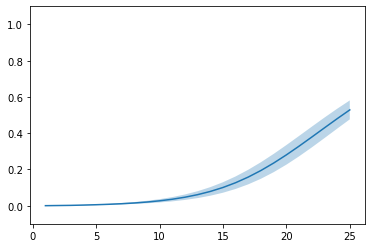

In [7]:
lower = strategy - dev
upper = strategy + dev 



plt.fill_between([x+1 for x in range(len(strategy))], lower, upper, alpha=.3)
plt.plot([x+1 for x in range(len(strategy))], strategy)
plt.ylim([-0.10,1.1])

In [16]:
import pickle as pkl

f1 = pkl.load( open( "x755_25_55.pkl", "rb" ) )

In [21]:
f['x755']['50_81']

{'average': array([1.99999999e-08, 2.21678390e-03, 8.06358212e-03, 2.82574177e-02,
        7.01884681e-02, 1.34604593e-01, 2.15139505e-01, 3.00947906e-01,
        3.82968709e-01, 4.56290297e-01, 5.19437097e-01, 5.73011005e-01,
        6.18697540e-01, 6.58637392e-01, 6.94882091e-01, 7.28814019e-01,
        7.60814836e-01, 7.90508728e-01, 8.17365737e-01, 8.41165427e-01,
        8.62118086e-01, 8.80731933e-01, 8.97546864e-01, 9.12872328e-01,
        9.26721351e-01]),
 'std': array([0.        , 0.00136822, 0.00495742, 0.01723107, 0.04187685,
        0.07765701, 0.11967365, 0.16233865, 0.20198495, 0.23664389,
        0.26528886, 0.28727696, 0.30195794, 0.30858435, 0.30674296,
        0.2971821 , 0.28221457, 0.26498376, 0.24807001, 0.23250808,
        0.21770024, 0.20206941, 0.18415946, 0.16368011, 0.14170677])}

In [18]:
f[''] = f1['x755']['25_55']

{'average': array([1.99999999e-08, 8.68381554e-04, 1.73400744e-03, 3.32511093e-03,
        5.25652792e-03, 7.68660396e-03, 1.08024472e-02, 1.48311433e-02,
        2.00537575e-02, 2.68158694e-02, 3.55341080e-02, 4.66957525e-02,
        6.08469332e-02, 7.85643414e-02, 1.00406448e-01, 1.26843971e-01,
        1.58175918e-01, 1.94445617e-01, 2.35377446e-01, 2.80355523e-01,
        3.28457749e-01, 3.78543515e-01, 4.29376804e-01, 4.79756050e-01,
        5.28622901e-01]),
 'std': array([0.        , 0.00030659, 0.00061007, 0.00116713, 0.00183878,
        0.0026767 , 0.00373932, 0.00509367, 0.00681667, 0.00899319,
        0.01170993, 0.01504374, 0.01904308, 0.02370305, 0.02893782,
        0.03455856, 0.04026862, 0.04568671, 0.05040026, 0.05403812,
        0.05633981, 0.05719841, 0.05666471, 0.0549169 , 0.05221117])}

In [22]:
new = {}

new['50_81'] = f['x755']['50_81']
new['25_55'] = f1['x755']['25_55']

In [25]:
f1['255'] = new

In [29]:
f1['x755'] = new

In [33]:
pkl.dump( f1, open( "all_4.pkl", "wb" ) )